In [24]:
library(tidyverse)
library(forcats)
library(tidymodels)
library(rvest)
library(gridExtra)
library(cowplot)



## Introduction
Heart disease is the leading cause of death for men, women, and people of most racial and ethnic groups in the world. About 697,000 people in the United States died from heart disease in 2020—that’s 1 in every 5 deaths. Heart disease cost the United States about $229 billion each year from 2017 to 2018. This includes the cost of healthcare services, medicines, and lost productivity due to death. In terms of the high mortality rate and huge cost of heart disease, we decided to make the theme of the project heart disease. In this project, our goal is to create a model to classify whether the patient has the risk of heart disease, hence identify potential heart disease patients for treatments. The database we use comes from UCI Machine learning and intelligent systems. This database contains 76 attributes, but all published experiments refer to using a subset of 14 of them. The goal of this dataset is also referred to the presence of heart disease in the patient. 

- **Research question**: Given the health profile of a patient, how accurate will our K-NN model be for predicting potential heart disease cases based on the selected explanatory variables?

**Data from: https://archive.ics.uci.edu/ml/datasets/Heart+Disease** 



# Preliminary exploratory data analysis





### Wrangling, Cleaning and definitng data

In [3]:
heart_disease_data <- 
read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data")

name <- c("age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang",
          "oldpeak","slope","ca","thal","status")

colnames(heart_disease_data) <- name

## change categorical data into category and combine the heart disease cases into either present or abscent
heart_disease_data_as_factors <- heart_disease_data|>
  mutate(
    sex=ifelse(sex== 1, "Male","Female"),                                 #Classify male and female 
    cp=ifelse(cp == 1, "typical",                                         #Classify chest pain type
       ifelse(cp == 2, "atypical", 
       ifelse(cp== 3, "non-anginal", 
              "asymptomatic"))),
    fbs=ifelse(fbs == 0, "Normal","High"),                                #Classify blood sugar level
    restecg=ifelse(restecg==0,"Normal",                                   #Classify 
            ifelse(restecg==1,"Abnormal","Definite")),
    exang=ifelse(exang==1,"yes","no"),
    slope=ifelse(slope == 1, "upsloping", 
                 ifelse(slope==2,"flat","downsloping")),
    ca=as_factor(ca),
    thal=ifelse(thal=="3.0","normal",
                ifelse(thal=="6.0","fixed defect","reversable defect")),
    status=ifelse(status==0,"absent","present"))|>                         # predicted variable
    mutate_if(is.character, as.factor)|>
    filter(ca!="?")

New names:
• `1.0` -> `1.0...2`
• `1.0` -> `1.0...3`
• `1.0` -> `1.0...6`
• `0.0` -> `0.0...9`
• `0.0` -> `0.0...12`
Rows: 302 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): 0.0...12, 6.0
dbl (12): 63.0, 1.0...2, 1.0...3, 145.0, 233.0, 1.0...6, 2.0, 150.0, 0.0...9...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## Split the training set and the test set

In [4]:
set.seed(1198)
heart_split <- initial_split(heart_disease_data_as_factors, prop = 0.8, strata = status)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

summary_table<-summary(heart_train)

summary_table

      age            sex                 cp         trestbps    
 Min.   :29.00   Female: 82   asymptomatic:117   Min.   :100.0  
 1st Qu.:48.00   Male  :156   atypical    : 45   1st Qu.:120.0  
 Median :56.00                non-anginal : 59   Median :130.0  
 Mean   :54.66                typical     : 17   Mean   :131.1  
 3rd Qu.:61.00                                   3rd Qu.:140.0  
 Max.   :77.00                                   Max.   :200.0  
      chol           fbs          restecg       thalach      exang    
 Min.   :126.0   High  : 36   Abnormal:  4   Min.   : 90.0   no :163  
 1st Qu.:211.0   Normal:202   Definite:112   1st Qu.:132.0   yes: 75  
 Median :242.5                Normal  :122   Median :152.5            
 Mean   :248.3                               Mean   :149.0            
 3rd Qu.:280.2                               3rd Qu.:165.8            
 Max.   :564.0                               Max.   :202.0            
    oldpeak              slope       ca         

## Comparing explanatory variables with predicted variables

### Examples of some more related explanatory variables
(suggested from result of logistic regression with α=0.1,see more from appendices section)

Categorical
- Gender
- Number of major vessels
- Chest pain level

Qualitative
- Resting blood pressure  
- Maximum heart rate 



`summarise()` has grouped output by 'cp'. You can override using the `.groups`
argument.


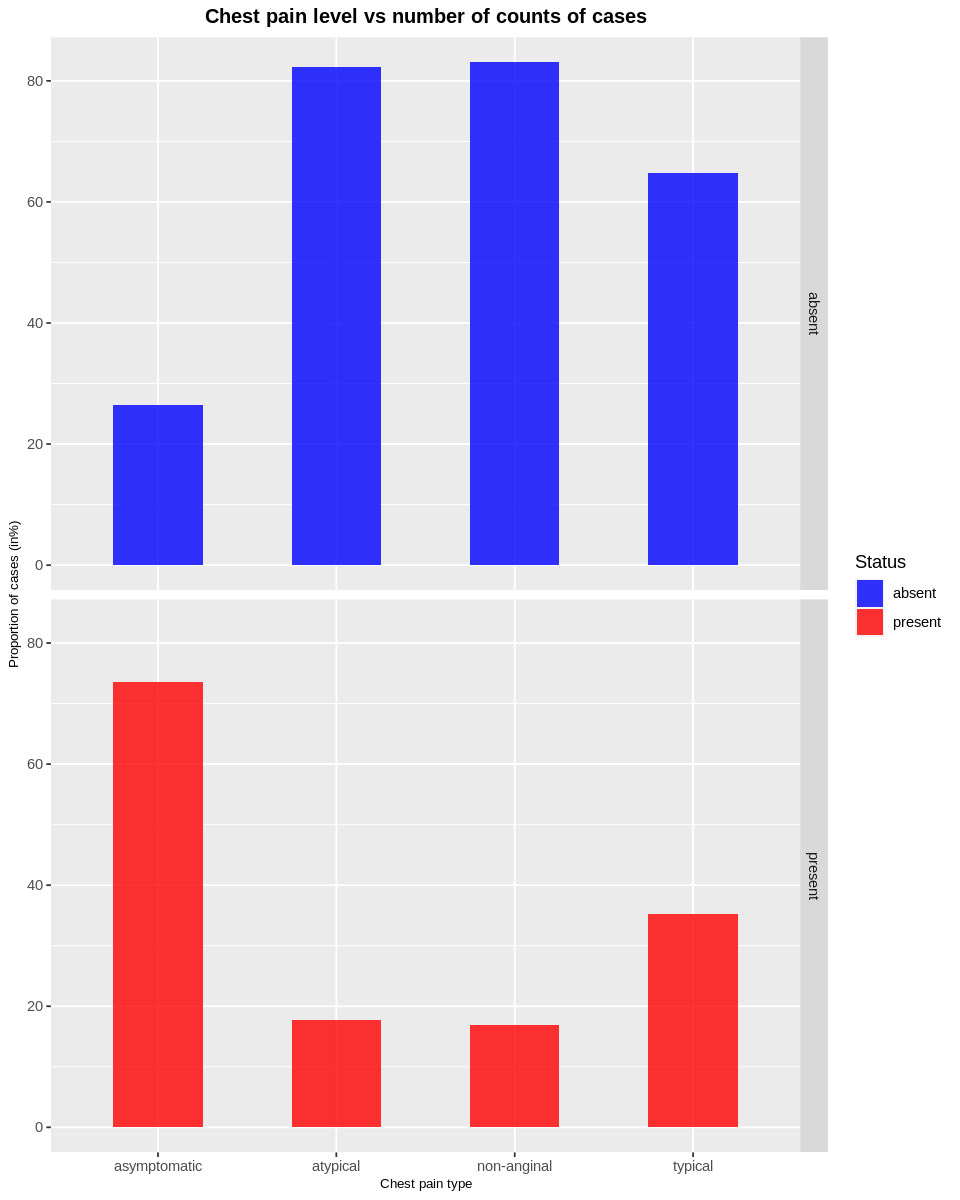

In [5]:
##Levels of chest pain vs heart disease cases

options(repr.plot.width = 8, repr.plot.height = 10)

chest_pain <- heart_train|>
    group_by(cp,status)|>
    summarize(count=n())|>
    mutate(percentage=count/sum(count))

cp_vs_newnum <- chest_pain|>
  ggplot(aes(x = cp, y = 100*percentage, fill=status)) + 
  geom_bar(stat = 'identity',width=0.5,alpha=0.8) +
  labs(x="Chest pain type",
       y="Proportion of cases (in%)",
       fill="Status",
       title="Chest pain level vs number of counts of cases")+
  facet_grid(row=vars(status))+
  theme(plot.title=element_text(size=12,face="bold"))+
  theme(plot.title=element_text(hjust=0.5))+
  theme(axis.title.x=element_text(size=8),axis.title.y=element_text(size=8))+
  scale_fill_manual(values=c('blue', 'red'))


cp_vs_newnum

**Result** : Heart disease seems to be dependnet on the type of chest pain that patient is experiencing 

`summarise()` has grouped output by 'sex'. You can override using the `.groups`
argument.


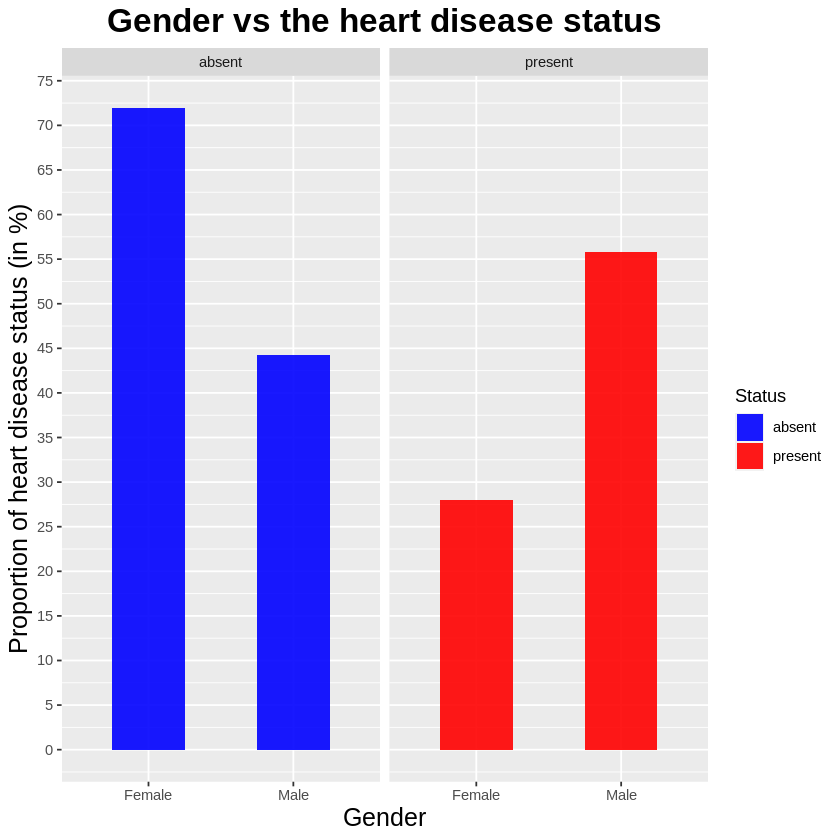

In [6]:
options(repr.plot.width = 7, repr.plot.height = 7)


gender <- heart_train|>
    group_by(sex,status)|>
    summarize(count=n())|>
    mutate(percentage=count/sum(count))

sex_vs_newnum <- gender|>
  ggplot(aes(x = sex, y = 100*percentage,fill=status)) + 
  geom_bar(stat="identity",alpha=0.9,width=0.5) +
  facet_grid(cols=vars(status))+
  labs(x="Gender",
       y="Proportion of heart disease status (in %)",
       fill="Status",
       title="Gender vs the heart disease status")+
  theme(plot.title=element_text(size=20,face="bold"))+
  theme(plot.title=element_text(hjust=0.5))+
  theme(axis.title.x=element_text(size=15),axis.title.y=element_text(size=15))+
  scale_y_continuous(breaks = seq(0, 100, by = 5))+
  scale_fill_manual(values=c('blue', 'red'))


sex_vs_newnum

**Result**: Male seems to have higher proportion of having heart disease then female.

`summarise()` has grouped output by 'ca'. You can override using the `.groups`
argument.


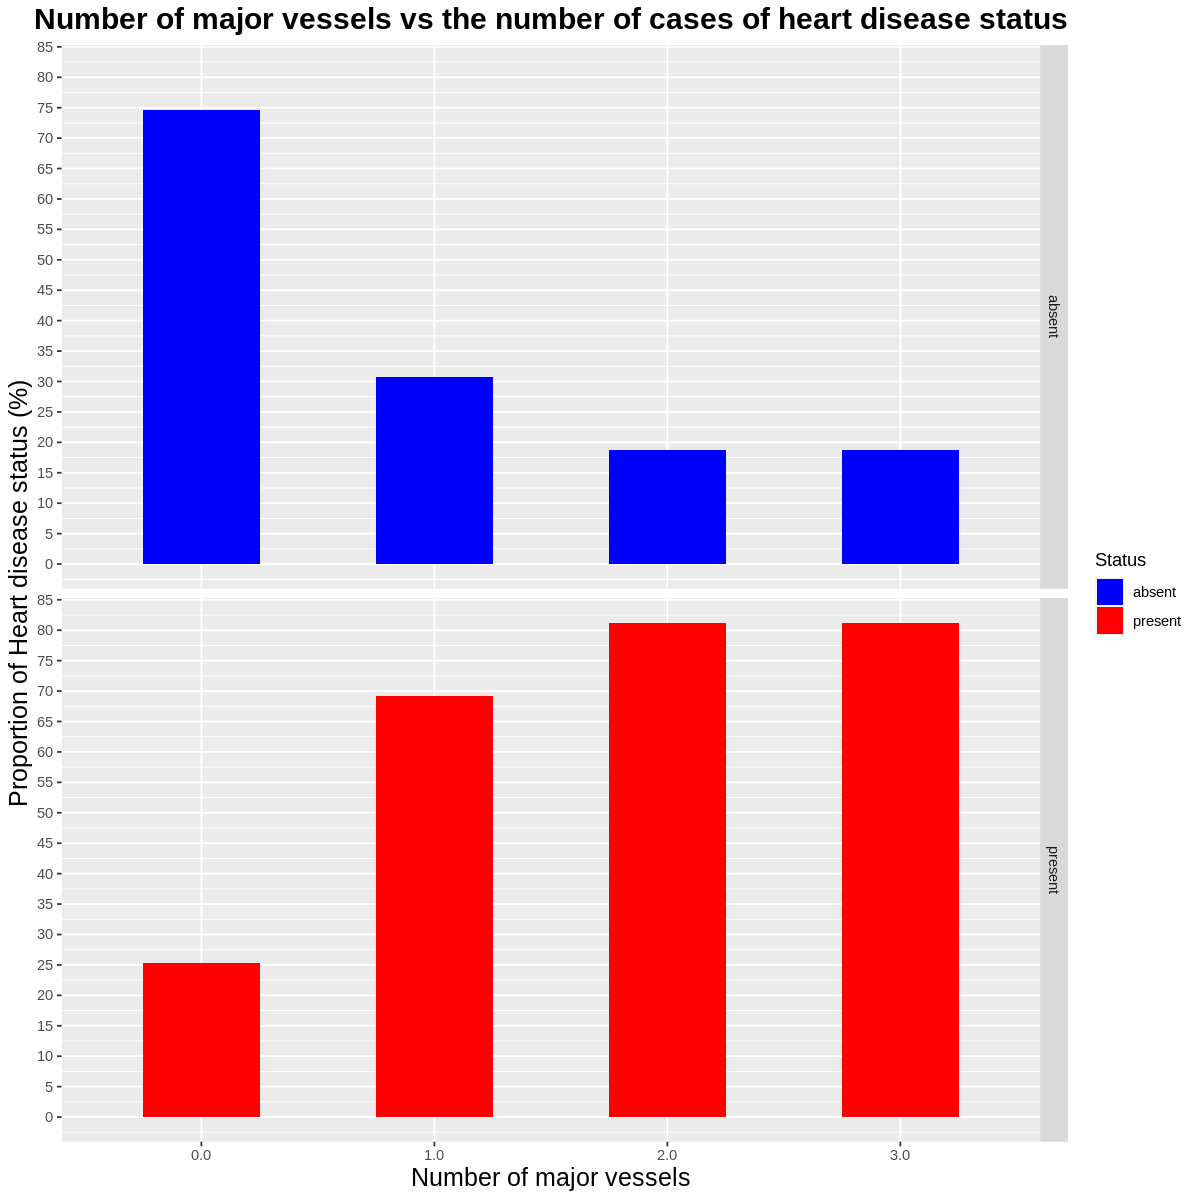

In [7]:
options(repr.plot.width = 10, repr.plot.height = 10)

major_vessels <- heart_train|>
    group_by(ca,status)|>
    summarize(count=n())|>
    mutate(percentage=count/sum(count))

ca_vs_status <- major_vessels|>
  ggplot(aes(x = factor(ca,c("0.0","1.0","2.0","3.0")), y=100*percentage,fill=status)) + 
  geom_bar(stat = "identity",width=0.5) +
  labs(x="Number of major vessels",
       y="Proportion of Heart disease status (%)",
       fill="Status",
       title="Number of major vessels vs the number of cases of heart disease status")+
  facet_grid(rows=vars(status))+
  theme(plot.title=element_text(size=18,face="bold"))+
  theme(plot.title=element_text(hjust=0.5))+
  theme(axis.title.x=element_text(size=15),axis.title.y=element_text(size=15))+
  scale_fill_manual(values=c('blue', 'red'))+
  scale_y_continuous(breaks = seq(0, 100, by = 5))

ca_vs_status


**Result**: Proportion of each sub-categories of number of major vessels are very different between each other and it seems like increasing in the number of major vessels have higher proportion of heart disease cases.

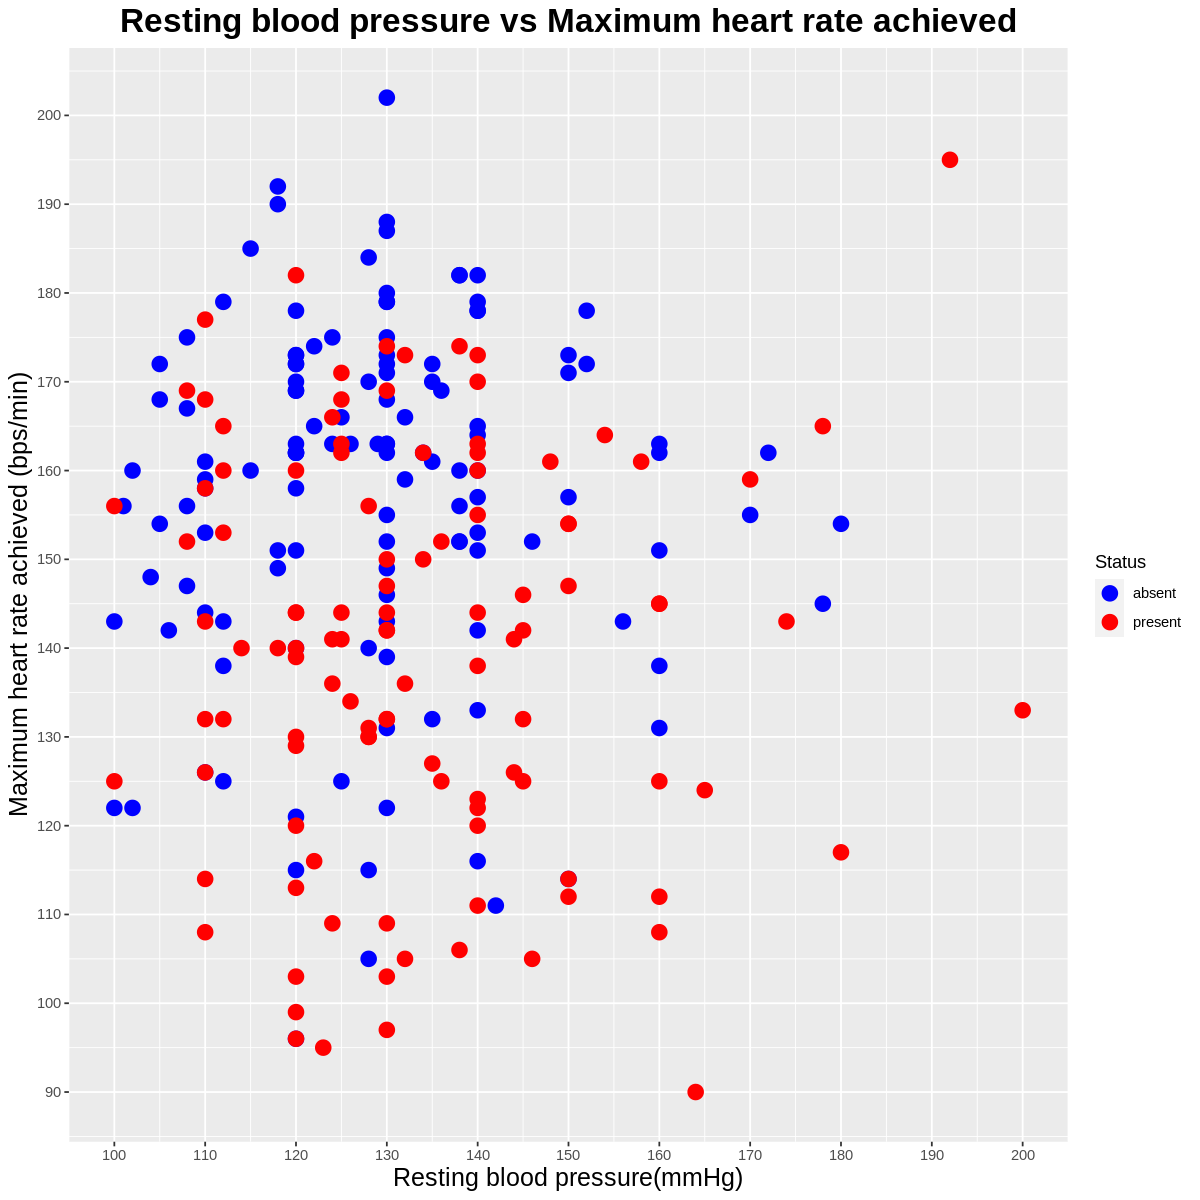

In [8]:
trestbps_vs_thalach <- heart_train|>
  ggplot(aes(x=trestbps,y=thalach,colour=status))+
  geom_point(size=4)+
  labs(x="Resting blood pressure(mmHg)",
         y="Maximum heart rate achieved (bps/min)",
         shape="Gender",
         color="Status",
         title="Resting blood pressure vs Maximum heart rate achieved")+
  theme(plot.title=element_text(size=20,face="bold"))+
  theme(plot.title=element_text(hjust=0.5))+
  theme(axis.title.x=element_text(size=15),axis.title.y=element_text(size=15))+
  scale_x_continuous(breaks = seq(0, 200, by = 10))+
  scale_y_continuous(breaks = seq(0, 200, by = 10))+
  scale_color_manual(values=c('blue', 'red'))

trestbps_vs_Status <- heart_train|>
  ggplot(aes(x = status, y=trestbps,colour=status)) + 
  geom_boxplot(alpha=0.7,size=1) +
  labs(x="Heart disease status",
       y="Maximum heart rate achieved (bps/min)",
       fill="Status",
       title="Maximum heart rate vs heart disease status")+
  theme(plot.title=element_text(size=12,face="bold"))+
  theme(plot.title=element_text(hjust=0.5))+
  theme(axis.title.x=element_text(size=10),axis.title.y=element_text(size=10))+
  scale_fill_manual(values=c('blue', 'red'))+
  scale_y_continuous(breaks= seq(25,80,by=5))

trestbps_vs_thalach

**Result**: The present or abscent of heart disease seem to cluster together between the above two quantitative variables

### **Examples of some less related explanatory variables**

Categorical
- Slope
- Thal

Qualitative
- Age
- Cholestro level

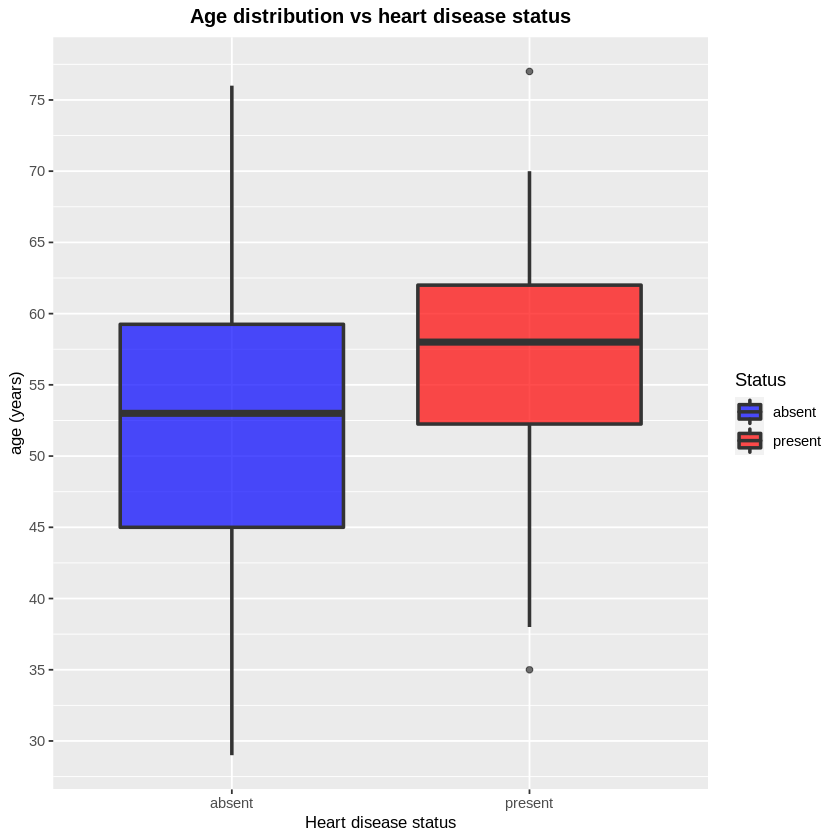

In [9]:
options(repr.plot.width = 7, repr.plot.height = 7)

Age_vs_Status <- heart_train|>
  ggplot(aes(x = status, y=age,fill=status)) + 
  geom_boxplot(alpha=0.7,size=1) +
  labs(x="Heart disease status",
       y="age (years)",
       fill="Status",
       title="Age distribution vs heart disease status")+
  theme(plot.title=element_text(size=12,face="bold"))+
  theme(plot.title=element_text(hjust=0.5))+
  theme(axis.title.x=element_text(size=10),axis.title.y=element_text(size=10))+
  scale_fill_manual(values=c('blue', 'red'))+
  scale_y_continuous(breaks= seq(25,80,by=5))

Age_vs_Status

**Result**:
Age seems to be more independent compare to other variables since distribution of box plots are similar

`summarise()` has grouped output by 'slope'. You can override using the
`.groups` argument.


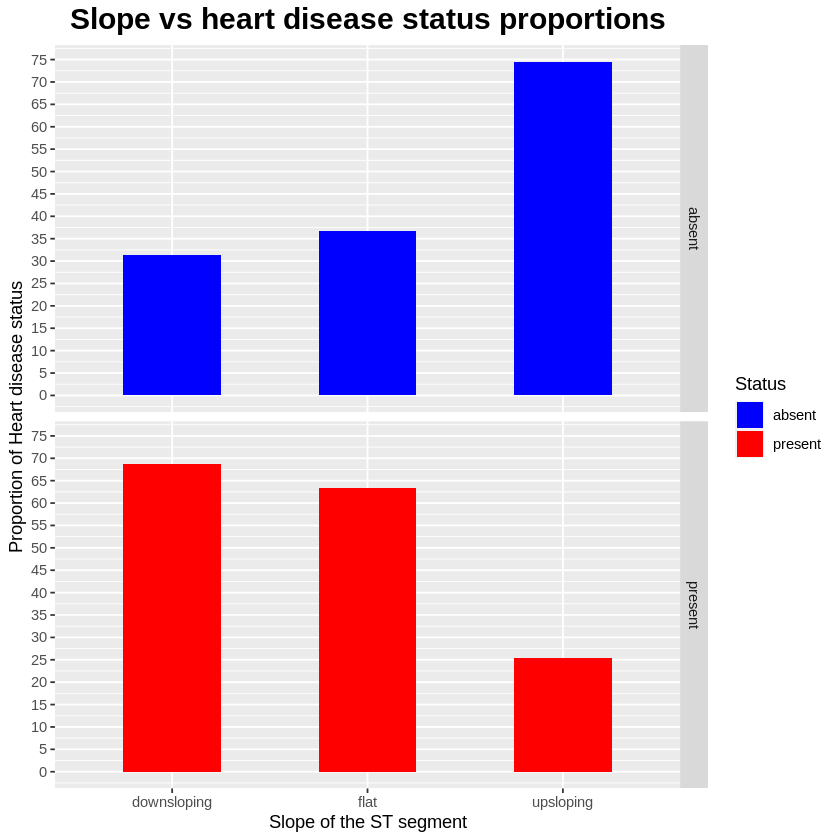

In [10]:
slope_count <- heart_train|>
    group_by(slope,status)|>
    summarize(count=n())|>
    mutate(percentage=count/sum(count))

slope_vs_status <- slope_count|>
  ggplot(aes(x = slope, y=100*percentage,fill=status)) + 
  geom_bar(stat = "identity",width=0.5) +
  labs(x="Slope of the ST segment",
       y="Proportion of Heart disease status",
       fill="Status",
       title="Slope vs heart disease status proportions")+
  facet_grid(rows=vars(status))+
  theme(plot.title=element_text(size=18,face="bold"))+
  theme(plot.title=element_text(hjust=0.5))+
  theme(axis.title.x=element_text(size=11),axis.title.y=element_text(size=11))+
  scale_fill_manual(values=c('blue', 'red'))+
  scale_y_continuous(breaks = seq(0, 100, by = 5))

slope_vs_status

**Result**: Only the "upsloping" category from slope seems to be related to absent or present of heart disease

`summarise()` has grouped output by 'thal'. You can override using the
`.groups` argument.


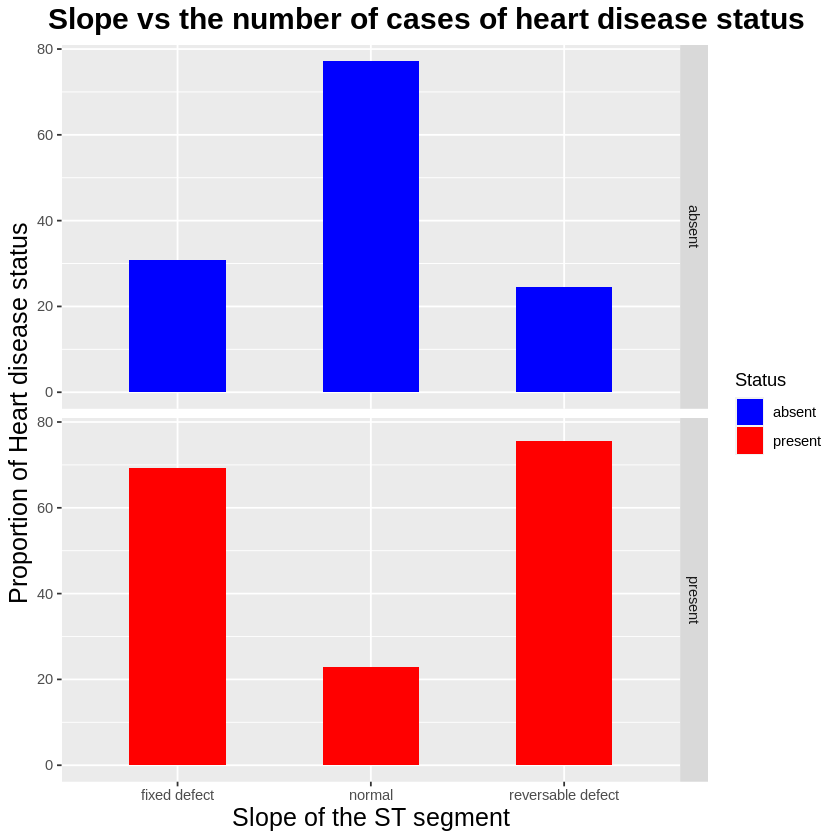

In [11]:
thal_count <- heart_train|>
    group_by(thal,status)|>
    summarize(count=n())|>
    mutate(percentage=count/sum(count))

thal_vs_status <- thal_count|>
  ggplot(aes(x = thal, y=100*percentage,fill=status)) + 
  geom_bar(stat = "identity",width=0.5) +
  labs(x="Slope of the ST segment",
       y="Proportion of Heart disease status",
       fill="Status",
       title="Slope vs the number of cases of heart disease status")+
  facet_grid(rows=vars(status))+
  theme(plot.title=element_text(size=18,face="bold"))+
  theme(plot.title=element_text(hjust=0.1))+
  theme(axis.title.x=element_text(size=15),axis.title.y=element_text(size=15))+
  scale_fill_manual(values=c('blue', 'red'))

thal_vs_status

**Result**: Only the normal type seems to be related to absent or present of heart disease

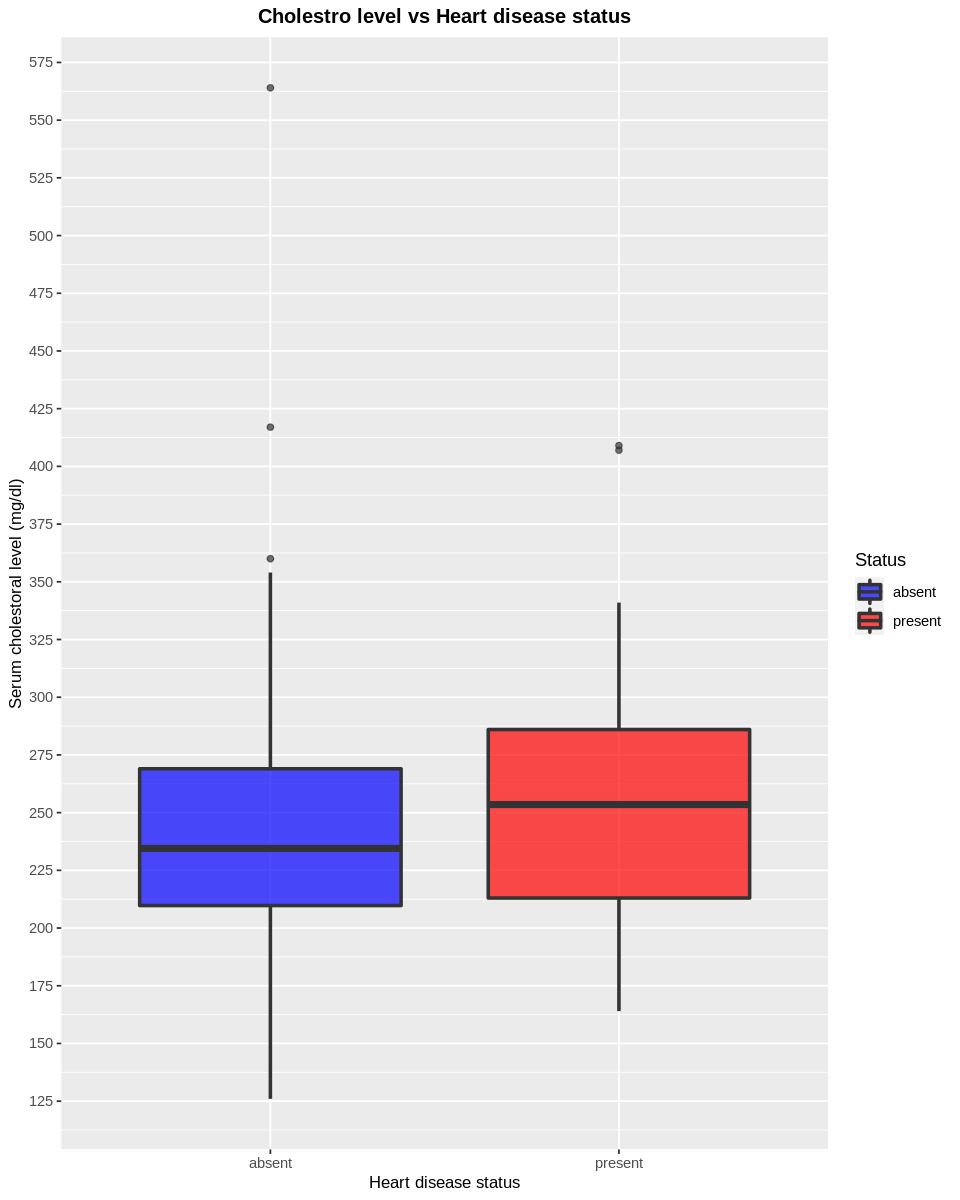

In [12]:
options(repr.plot.width = 8, repr.plot.height = 10)

Chol_vs_Status <- heart_train|>
  ggplot(aes(x = status, y=chol,fill=status)) + 
  geom_boxplot(alpha=0.7,size=1) +
  labs(x="Heart disease status",
       y="Serum cholestoral level (mg/dl)",
       fill="Status",
       title="Cholestro level vs Heart disease status")+
  theme(plot.title=element_text(size=12,face="bold"))+
  theme(plot.title=element_text(hjust=0.5))+
  theme(axis.title.x=element_text(size=10),axis.title.y=element_text(size=10))+
  scale_fill_manual(values=c('blue', 'red'))+
  scale_y_continuous(breaks = seq(100, 600, by = 25))

Chol_vs_Status

**Result**:
Both box plot have similar distribution, suggesting more independence between cholestoral level and heart disase 

## Conclusion

Out of all the 13 explanatory variables, these are the following variables we want to include in the model for classification of heart disease status

- Sex
- Maximum heart rate
- Resting blood pressure
- Chest pain level
- Number of major vessels

## Appendicies: significant levels of explanatory vairables from logistic regression

In [13]:
model <- glm(status ~ .,
                    family = binomial,
                    data=heart_train)

summary(model)


Call:
glm(formula = status ~ ., family = binomial, data = heart_train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.0221  -0.4691  -0.1170   0.3043   3.1521  

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)            0.673449   5.142319   0.131  0.89581    
age                   -0.044359   0.029557  -1.501  0.13341    
sexMale                1.171117   0.618319   1.894  0.05822 .  
cpatypical            -1.276620   0.638532  -1.999  0.04558 *  
cpnon-anginal         -2.751235   0.691392  -3.979 6.91e-05 ***
cptypical             -2.258077   0.780688  -2.892  0.00382 ** 
trestbps               0.022650   0.013384   1.692  0.09058 .  
chol                   0.006303   0.004670   1.350  0.17711    
fbsNormal              0.452701   0.654513   0.692  0.48915    
restecgDefinite       -1.412345   3.726609  -0.379  0.70470    
restecgNormal         -1.863720   3.726968  -0.500  0.61703    
thalach               -0.003257

## Methods:

Having cleaned and compared the graphs of different variables with indication of presence or absence of heart diseases, we have decided to focus on a few variables which display noticeable patterns between heart disease positive and heart disease negative data points. These variables include sex, chest pain type, resting blood pressure, maximum heart rate achieved, and number of major vessels coloured by fluoroscopy of the patient. We are going to build a classification model which references selected data found in the data set, and use this classification model to answer our predictive question – **can our model classify whether the patient has the risk of heart disease, based on our selected variables?** After the question is answered by the classification model, we will be plotting the new data in each of the graphs with our selected variables to see if the answer made sense.
 
#### What do you expect to find?
We expect to find accurate classification when given unclassified objects, all related to the variables mentioned in the introduction. We will also expect to evaluate the accuracy of the model

#### What impact could such findings have?
It is important to be able to detect heart disease efficiently and quickly because of the lasting effects it has on health. Accurate detection and classification could jumpstart treatment of heart disease, as well as lifestyle, medication, and diet adjustment to prevent further progression of heart/cardiovascular disease.

#### What future questions could this lead to?
Are these variables enough to accurately classify heart disease in individuals? Is there any way to improve this classification, ie. with fewer variables (while maintaining accuracy), to contribute to a lesser workload and/or less testing in individuals?
**Result**: Only the normal type seems to be related to absent or present of heart disease